# Initial Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# Preprocessing

In [ ]:
# Preprocess dataset (Outputs: ids, trial_nums, predictors_df, outcomes_df, outcomes_df_shuffled)
# Import dataset
df = pd.read_csv("./../../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv").replace([np.inf, -np.inf], np.nan)

# Create Low vs High Columns
df["Lv_1_Lo"] = (df["SA1"] < 5).astype(np.bool_)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(np.bool_)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(np.bool_)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(np.bool_)

# Impute missing values with mean of column
for col in df.columns:
    df[col] = df[col].fillna(value = df[col].mean())

# Split up dataset
ids = df["ID"].astype(np.uint8)
predictors_df = df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal", "Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]).astype(np.float64)
outcomes_df = df[["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]
outcomes_df_shuffled = outcomes_df.copy()

# Shuffle labels for shuffled data
outcomes_df_shuffled["Lv_1_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_1_Lo"])
outcomes_df_shuffled["Lv_2_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_2_Lo"])
outcomes_df_shuffled["Lv_3_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_3_Lo"])
outcomes_df_shuffled["Tot_Lo"] = np.random.permutation(outcomes_df_shuffled["Tot_Lo"])

# Divide up dataframe
ECG_df = df.loc[:, [col for col in df if col.startswith("ECG")]]
EDA_df = df.loc[:, [col for col in df if col.startswith("EDA")]]
EEG_df = df.loc[:, [col for col in df if col.startswith("EEG")]]
EYE_df = df.loc[:, [col for col in df if col.startswith("EYE")]]
fNIRS_df = df.loc[:, [col for col in df if col.startswith("fNIRS")]]
RSP_df = df.loc[:, [col for col in df if col.startswith("RSP")]]
sensor_dfs = [(ECG_df, "ECG"), (EDA_df, "EDA"), (EEG_df, "EEG"), (EYE_df, "EYE"), (fNIRS_df, "fNIRS"), (RSP_df, "RSP")]

# Free up memory
del col, df, predictors_df

In [3]:
# Initialize f1_scores, accuracy_scores, models
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]
sensor_names = ["ECG", "EDA", "EEG", "EYE", "fNIRS", "RSP"]

f1_scores = {}
accuracy_scores = {}
models = {}

for data in [f1_scores, accuracy_scores, models]:
    for dataset in dataset_types:
        data[dataset] = {}

        for level in levels:
            data[dataset][level] = {}

            for sensor in sensor_names:
                data[dataset][level][sensor] = []

del data, dataset, sensor, level

# Training

In [13]:
def train_sensor_models(pred_df, out_df, level):
    f1_sensor_scores = []
    accuracy_sensor_scores = []
    sensor_models = []

    # Obtain 10 test folds stratifying by participant ID
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (train_idx, test_idx) in enumerate(skf.split(pred_df, ids)):
        # Train-Test Split for the Fold
        pred_train = pred_df.iloc[train_idx, :].values
        pred_test = pred_df.iloc[test_idx, :].values
        out_train = out_df.loc[train_idx, level].values
        out_test = out_df.loc[test_idx, level].values
        train_ids = ids.iloc[train_idx].values

        # Hyperparameter Tuning
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegressionCV(
                Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42).split(train_ids, out_train),
                penalty = "l2",
                max_iter = 20000,
                scoring = "f1",
                class_weight = "balanced",
                n_jobs = -1,
                random_state = 42
            ))
        ])
        pipeline.fit(pred_train, out_train)
        pipeline.named_steps["model"].cv = None
        predictions = pipeline.predict(pred_test)

        # Take Note of Metrics and Model
        f1_sensor_scores.append(f1_score(out_test, predictions))
        accuracy_sensor_scores.append(accuracy_score(out_test, predictions))
        sensor_models.append(pipeline.named_steps["model"])

        del pred_train, pred_test, out_train, out_test, train_ids, predictions, pipeline

    return f1_sensor_scores, accuracy_sensor_scores, sensor_models

In [14]:
for dataset_type in dataset_types:
    for level in levels:
        for sensor_df, sensor in sensor_dfs:
            if dataset_type == "Actual":
                f1_scores[dataset_type][level][sensor], accuracy_scores[dataset_type][level][sensor], models[dataset_type][level][sensor] = train_sensor_models(sensor_df, outcomes_df, level)
            else:
                f1_scores[dataset_type][level][sensor], accuracy_scores[dataset_type][level][sensor], models[dataset_type][level][sensor] = train_sensor_models(sensor_df, outcomes_df_shuffled, level)
            
            print("Completed Training for", dataset_type, level, sensor)

Completed Training for Actual Lv_1_Lo ECG
Completed Training for Actual Lv_1_Lo EDA
Completed Training for Actual Lv_1_Lo EEG
Completed Training for Actual Lv_1_Lo EYE
Completed Training for Actual Lv_1_Lo fNIRS
Completed Training for Actual Lv_1_Lo RSP
Completed Training for Actual Lv_2_Lo ECG
Completed Training for Actual Lv_2_Lo EDA
Completed Training for Actual Lv_2_Lo EEG
Completed Training for Actual Lv_2_Lo EYE
Completed Training for Actual Lv_2_Lo fNIRS
Completed Training for Actual Lv_2_Lo RSP
Completed Training for Actual Lv_3_Lo ECG
Completed Training for Actual Lv_3_Lo EDA
Completed Training for Actual Lv_3_Lo EEG
Completed Training for Actual Lv_3_Lo EYE
Completed Training for Actual Lv_3_Lo fNIRS
Completed Training for Actual Lv_3_Lo RSP
Completed Training for Actual Tot_Lo ECG
Completed Training for Actual Tot_Lo EDA
Completed Training for Actual Tot_Lo EEG
Completed Training for Actual Tot_Lo EYE
Completed Training for Actual Tot_Lo fNIRS
Completed Training for Actual T

In [32]:
# Save data
with open("./../../Pickle Files/3_Moving_Average_Model_by_Sensor_With_Intercepts.pkl", "wb") as f:
    pickle.dump((f1_scores, accuracy_scores, models), f)

In [ ]:
# Load data
with open("./../../Pickle Files/3_Moving_Average_Model_by_Sensor_With_Intercepts.pkl", "rb") as f:
    f1_scores, accuracy_scores, models = pickle.load(f)

# Evaluating Individual Sensor Models

In [15]:
def sensor_actual_vs_shuffled(model_scores, metric, level):
    for sensor in ["ECG", "EDA", "EEG", "EYE", "fNIRS", "RSP"]:
        # Intiailize Baselines
        baselines = []
        always_true_lines = []
        always_false_lines = []

        # Get baselines for each fold
        skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
        for i, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            # Train-Test Split for the Fold
            out_test = outcomes_df.iloc[test_idx]

            if metric == "F1":
                baselines.append((np.mean(out_test[level])) / (np.mean(out_test[level]) + 0.5))
                always_true_lines.append(f1_score(out_test[level], np.array([1 for _ in range(len(out_test[level]))])))
            elif metric == "Accuracy":
                baselines.append(0.5)
                always_false_lines.append(accuracy_score(outcomes_df[level], np.array([0 for _ in range(len(outcomes_df[level]))])))

        fig = plt.figure(figsize = (7.5, 7.5))

        actual_scores = model_scores["Actual"][level][sensor]
        shuffled_scores = model_scores["Shuffled"][level][sensor]

        # Plot Actual vs Shuffled
        for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
            plt.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

        # Model 1 Data Boxplot
        plt.boxplot(actual_scores, vert = True, positions = [-0.1])

        # Shuffled Data Boxplot
        plt.boxplot(shuffled_scores, vert = True, positions = [1.1])

        # Baselines
        if metric == "F1":
            plt.axhline(y = np.mean(always_true_lines), color = "r", label = "Always True", linestyle = "--")
        elif metric == "Accuracy":
            plt.axhline(y = np.mean(always_false_lines), color = "b", label = "Always True", linestyle = "--")
        plt.axhline(y = np.mean(baselines), color = "black", label = "Baseline", linestyle = "--")

        # Visual Adjustments
        plt.xticks([0, 1], ["Actual", "Shuffled"])
        plt.xlim([-0.2, 1.2])
        plt.ylim([0, 1])
        
        # Labeling
        plt.xlabel("Model Type")
        plt.ylabel(f"{metric} Score")
        plt.title(f"{sensor} {metric} Test Fold Scores for {level} Models")
        plt.legend(loc = "upper right", bbox_to_anchor = [1.3, 1])
        
        plt.show()

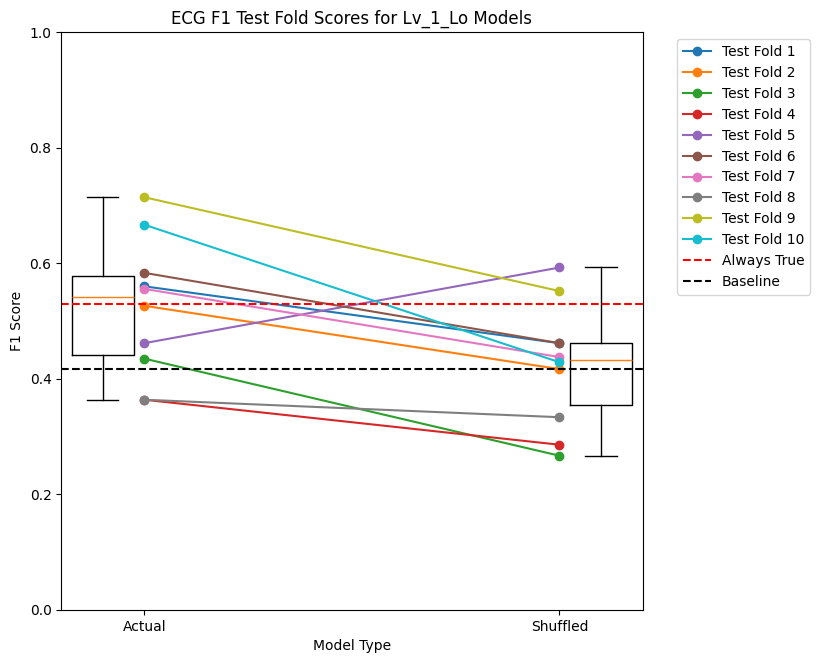

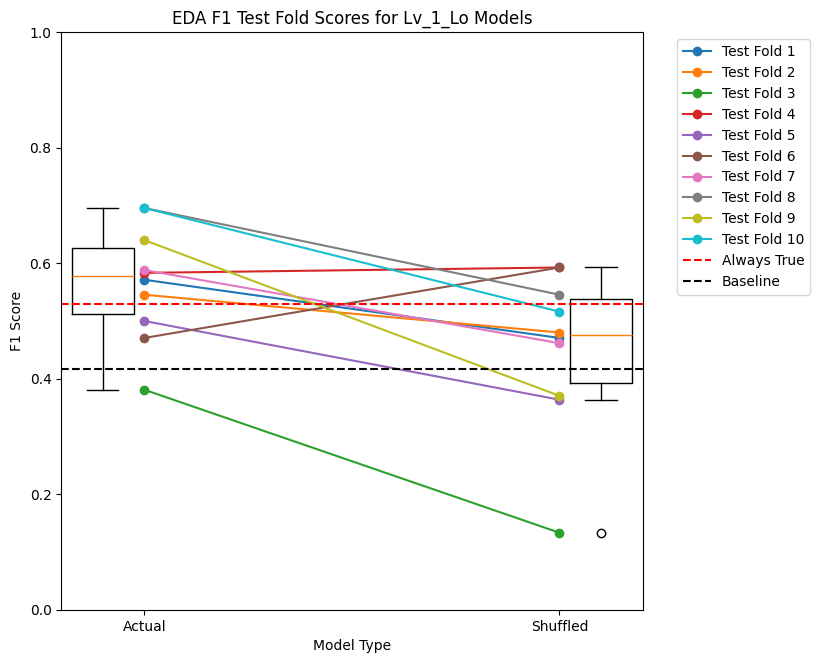

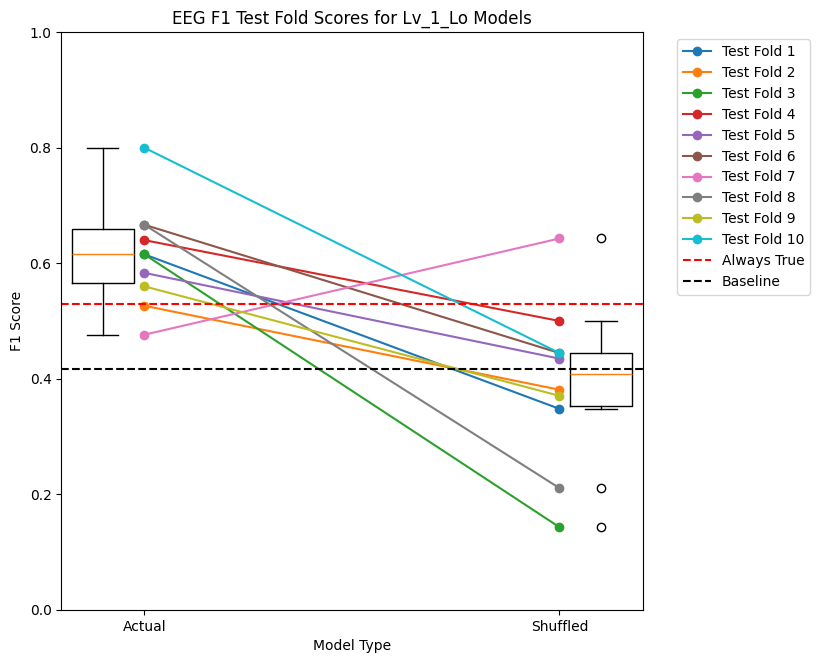

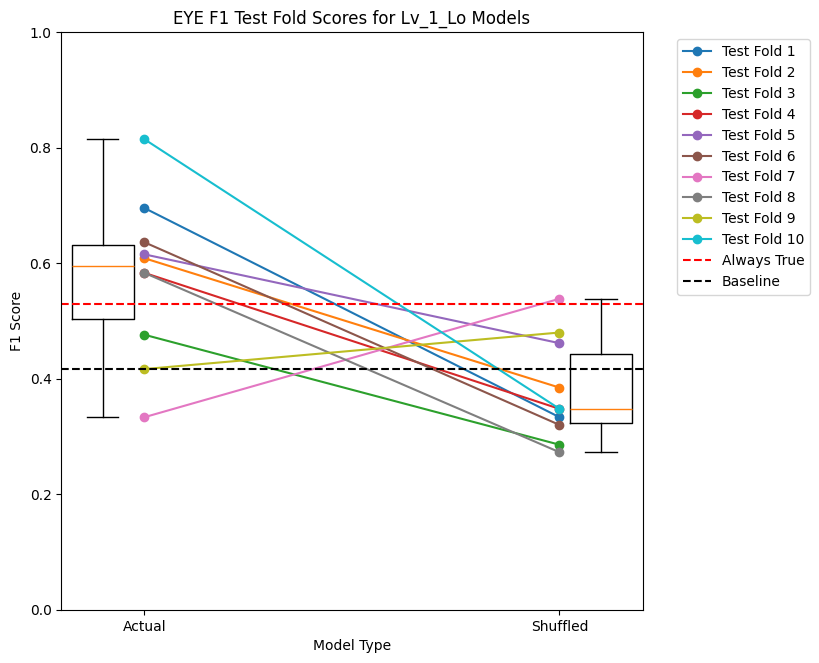

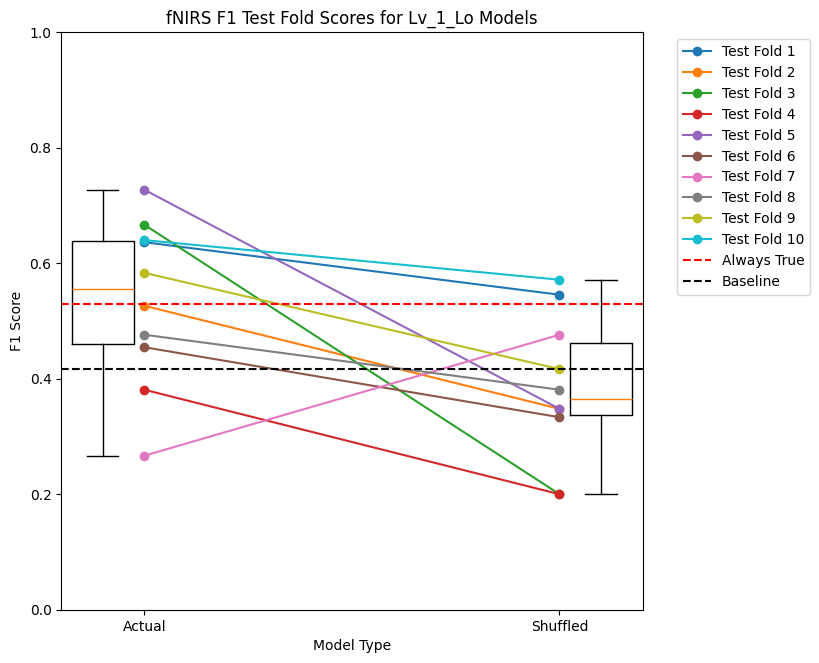

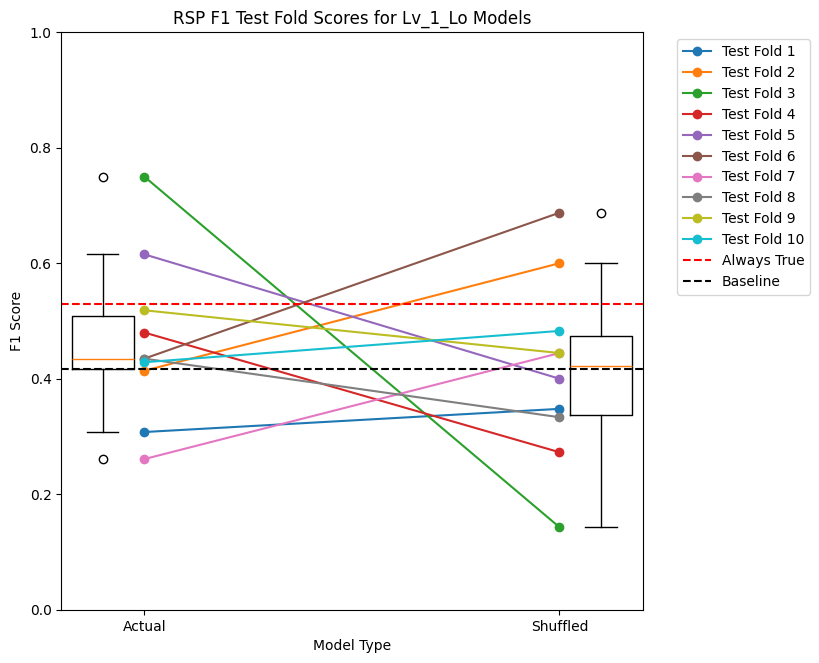

In [16]:
sensor_actual_vs_shuffled(f1_scores, "F1", "Lv_1_Lo")

# Majority Voting

In [3]:
# Load data
with open("./../../Pickle Files/3_Moving_Average_Model_by_Sensor_With_Intercepts.pkl", "rb") as f:
    f1_scores, accuracy_scores, models = pickle.load(f)

del f1_scores, accuracy_scores, f

## Get Predictions

In [4]:
# Initialize data storage
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]

majority_voting_predictions = {}

for dataset in dataset_types:
    majority_voting_predictions[dataset] = {}

    for level in levels:
        majority_voting_predictions[dataset][level] = []

del dataset, level

In [5]:
# Tally up and store majority voting predictions
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for level in levels:
        for i, (train_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            votes = np.array([0 for _ in range(len(test_idx))])

            for sensor, df in [("ECG", ECG_df), ("EDA", EDA_df), ("EEG", EEG_df), ("EYE", EYE_df), ("fNIRS", fNIRS_df)]:
                # Train-Test Split for the Fold
                pred_train = df.iloc[train_idx, :]
                pred_test = df.iloc[test_idx, :]

                # Standardize Data
                scaler = StandardScaler()
                pred_train_normalized = scaler.fit_transform(pred_train)
                pred_test_normalized = scaler.transform(pred_test)

                # Free Up Memory
                del pred_train, pred_train_normalized, pred_test

                votes = np.add(votes, models[dataset_type][level][sensor][i].predict(pred_test_normalized).astype(int))

                majority_voting_predictions[dataset_type][level].append(votes >= 3)

del models
del skf, dataset_type, level, i, train_idx, test_idx, votes, sensor, df, pred_test_normalized, scaler

## Get F1 and Accuracy Scores

In [6]:
# Initialize f1_scores and accuracy_scores
f1_scores = {}
accuracy_scores = {}

for data in [f1_scores, accuracy_scores]:
    for dataset in dataset_types:
        data[dataset] = {}

        for level in levels:
            data[dataset][level] = []

del data, dataset, level

In [7]:
# Calculate F1 and Accuracy Scores
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for level in levels:
        for i, (CV_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            out_test = outcomes_df.loc[test_idx, level].values

            f1_scores[dataset_type][level].append(f1_score(out_test, majority_voting_predictions[dataset_type][level][i]))
            accuracy_scores[dataset_type][level].append(accuracy_score(out_test, majority_voting_predictions[dataset_type][level][i]))

del skf, dataset_type, level, i, CV_idx, test_idx, out_test

## Graphing

In [9]:
def graph_actual_vs_shuffled(model_scores, metric, level):
    # Intiailize Baselines
    baselines = []
    always_true_lines = []
    always_false_lines = []
 
    # Get baselines for each fold
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
        # Train-Test Split for the Fold
        out_test = outcomes_df.iloc[test_idx]

        if metric == "F1":
            baselines.append((np.mean(out_test[level])) / (np.mean(out_test[level]) + 0.5))
            always_true_lines.append(f1_score(out_test[level], np.array([1 for _ in range(len(out_test[level]))])))
        elif metric == "Accuracy":
            baselines.append(0.5)
            always_false_lines.append(accuracy_score(outcomes_df[level], np.array([0 for _ in range(len(outcomes_df[level]))])))

    fig = plt.figure(figsize = (7.5, 7.5))

    actual_scores = model_scores["Actual"][level]
    shuffled_scores = model_scores["Shuffled"][level]

    # Plot Actual vs Shuffled
    for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
        plt.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

    # Model 1 Data Boxplot
    plt.boxplot(actual_scores, vert = True, positions = [-0.1])

    # Shuffled Data Boxplot
    plt.boxplot(shuffled_scores, vert = True, positions = [1.1])

    # Baselines
    if metric == "F1":
        plt.axhline(y = np.mean(always_true_lines), color = "r", label = "Always True", linestyle = "--")
    elif metric == "Accuracy":
        plt.axhline(y = np.mean(always_false_lines), color = "b", label = "Always True", linestyle = "--")
    plt.axhline(y = np.mean(baselines), color = "black", label = "Baseline", linestyle = "--")

    # Visual Adjustments
    plt.xticks([0, 1], ["Actual", "Shuffled"])
    plt.xlim([-0.2, 1.2])
    plt.ylim([0, 1])
    
    # Labeling
    plt.xlabel("Model Type")
    plt.ylabel(f"{metric} Score")
    plt.title(f"{metric} Test Fold Scores for {level} Models")
    plt.legend(loc = "upper right", bbox_to_anchor = [1.3, 1])
    
    plt.show()

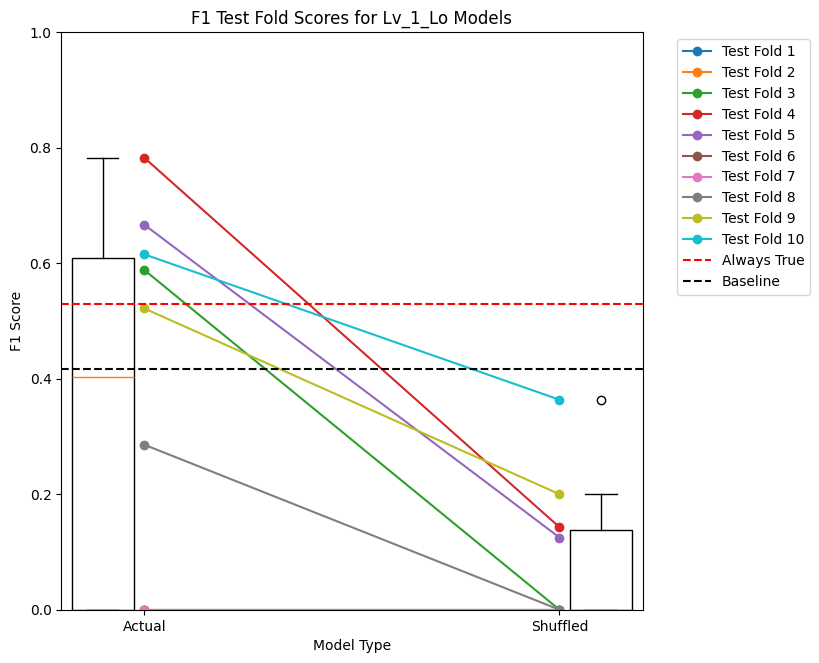

In [10]:
graph_actual_vs_shuffled(f1_scores, "F1", "Lv_1_Lo")

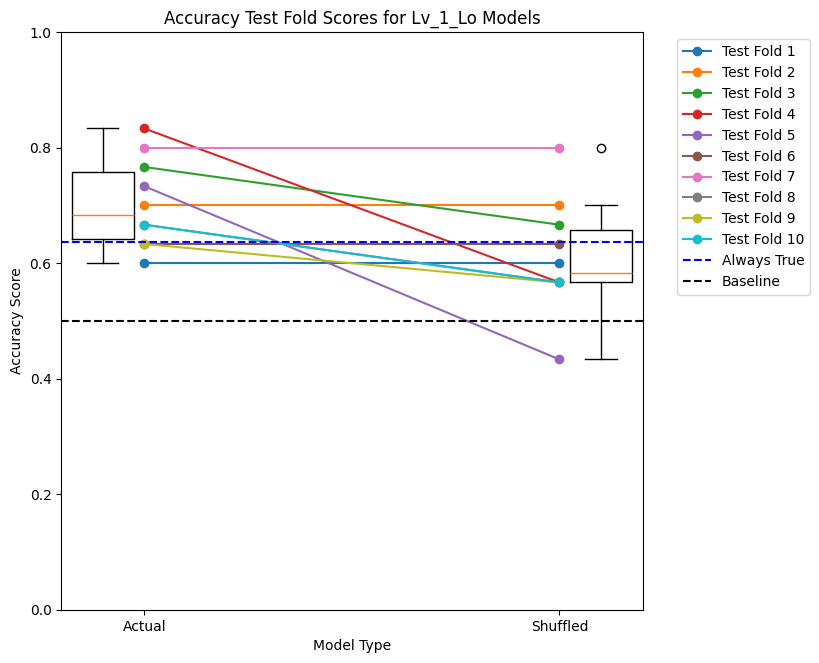

In [22]:
graph_actual_vs_shuffled(accuracy_scores, "Accuracy", "Lv_1_Lo")

# Average Probability

In [4]:
# Load data
with open("./../../Pickle Files/3_Moving_Average_Model_by_Sensor_With_Intercepts.pkl", "rb") as f:
    f1_scores, accuracy_scores, models = pickle.load(f)

del f1_scores, accuracy_scores, f

## Get Predictions

In [5]:
# Initialize data storage
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]

average_probability_predictions = {}

for dataset in dataset_types:
    average_probability_predictions[dataset] = {}

    for level in levels:
        average_probability_predictions[dataset][level] = []

del dataset, level

In [6]:
# Tally up and store majority voting predictions
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for level in levels:
        for i, (train_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            votes = np.array([0.0 for _ in range(len(test_idx))])

            for sensor, df in [("ECG", ECG_df), ("EDA", EDA_df), ("EEG", EEG_df), ("EYE", EYE_df), ("fNIRS", fNIRS_df)]:
                # Train-Test Split for the Fold
                pred_train = df.iloc[train_idx, :]
                pred_test = df.iloc[test_idx, :]

                # Standardize Data
                scaler = StandardScaler()
                pred_train_normalized = scaler.fit_transform(pred_train)
                pred_test_normalized = scaler.transform(pred_test)

                # Free Up Memory
                del pred_train, pred_train_normalized, pred_test

                votes = np.add(votes, models[dataset_type][level][sensor][i].predict_proba(pred_test_normalized)[:, 1])

            average_probability_predictions[dataset_type][level].append(votes >= 2.5)

del models
del skf, dataset_type, level, i, train_idx, test_idx, votes, sensor, df, pred_test_normalized, scaler

## Get F1 and Accuracy Scores

In [7]:
# Initialize f1_scores and accuracy_scores
f1_scores = {}
accuracy_scores = {}

for data in [f1_scores, accuracy_scores]:
    for dataset in dataset_types:
        data[dataset] = {}

        for level in levels:
            data[dataset][level] = []

del data, dataset, level

In [8]:
# Calculate F1 and Accuracy Scores
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for lvl in levels:
        for i, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            out_test = outcomes_df.loc[test_idx, lvl].values

            f1_scores[dataset_type][lvl].append(f1_score(out_test, average_probability_predictions[dataset_type][lvl][i]))
            accuracy_scores[dataset_type][lvl].append(accuracy_score(out_test, average_probability_predictions[dataset_type][lvl][i]))

del skf, dataset_type, lvl, i, test_idx, out_test

In [10]:
# Save data
with open("./Average_Probability_With_Intercept_Scores.pkl", "wb") as f:
    pickle.dump((f1_scores, accuracy_scores), f)

## Graphing

In [12]:
def graph_all_actual_vs_shuffled(model_scores, metric):
    for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
        graph_actual_vs_shuffled(model_scores, metric, level)

def graph_actual_vs_shuffled(model_scores, metric, level):
    # Intiailize Baselines
    baselines = []
    always_true_lines = []
    always_false_lines = []

    # Get baselines for each fold
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
        # Train-Test Split for the Fold
        out_test = outcomes_df.iloc[test_idx]

        if metric == "F1":
            baselines.append((np.mean(out_test[level])) / (np.mean(out_test[level]) + 0.5))
            always_true_lines.append(f1_score(out_test[level], np.array([1 for _ in range(len(out_test[level]))])))
        elif metric == "Accuracy":
            baselines.append(0.5)
            always_false_lines.append(accuracy_score(outcomes_df[level], np.array([0 for _ in range(len(outcomes_df[level]))])))

    fig = plt.figure(figsize = (7.5, 7.5))

    actual_scores = model_scores["Actual"][level]
    shuffled_scores = model_scores["Shuffled"][level]

    # Plot Actual vs Shuffled
    for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
        plt.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

    # Model 1 Data Boxplot
    plt.boxplot(actual_scores, vert = True, positions = [-0.1])

    # Shuffled Data Boxplot
    plt.boxplot(shuffled_scores, vert = True, positions = [1.1])

    # Baselines
    if metric == "F1":
        plt.axhline(y = np.mean(always_true_lines), color = "r", label = "Always True", linestyle = "--")
    elif metric == "Accuracy":
        plt.axhline(y = np.mean(always_false_lines), color = "b", label = "Always True", linestyle = "--")
    plt.axhline(y = np.mean(baselines), color = "black", label = "Baseline", linestyle = "--")

    # Visual Adjustments
    plt.xticks([0, 1], ["Actual", "Shuffled"])
    plt.xlim([-0.2, 1.2])
    plt.ylim([0, 1])
    
    # Labeling
    plt.xlabel("Model Type")
    plt.ylabel(f"{metric} Score")
    plt.title(f"{metric} Test Fold Scores for {level} Models")
    plt.legend(loc = "upper right", bbox_to_anchor = [1.3, 1])
    
    plt.show()

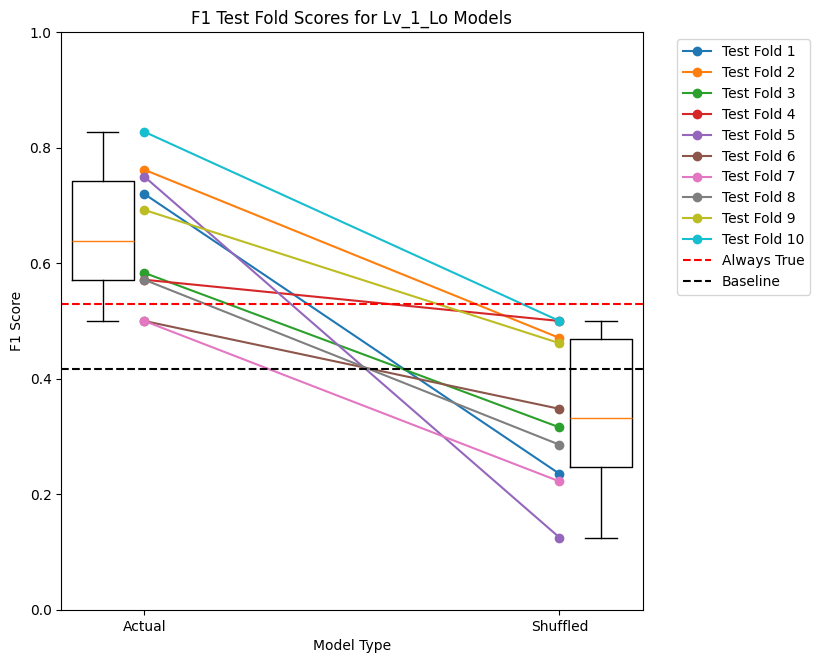

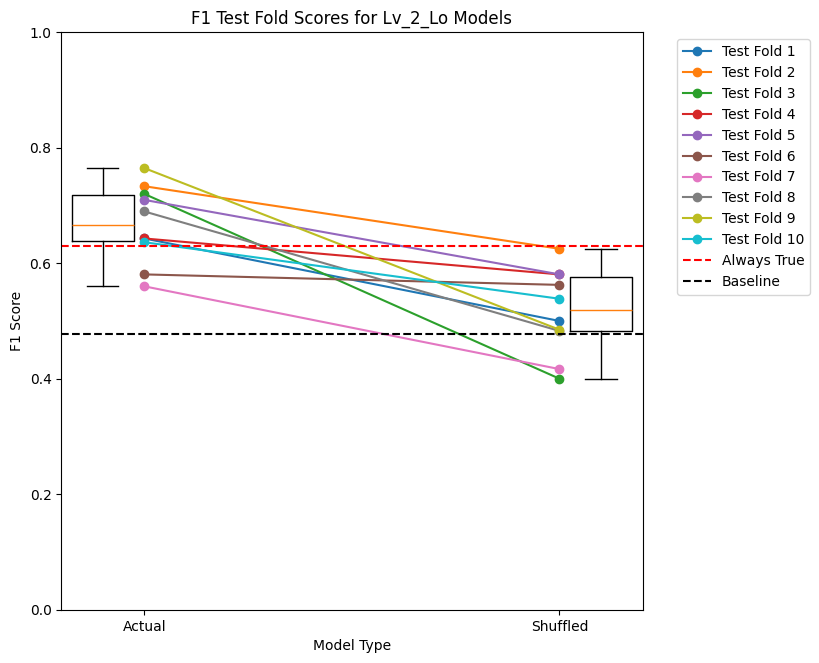

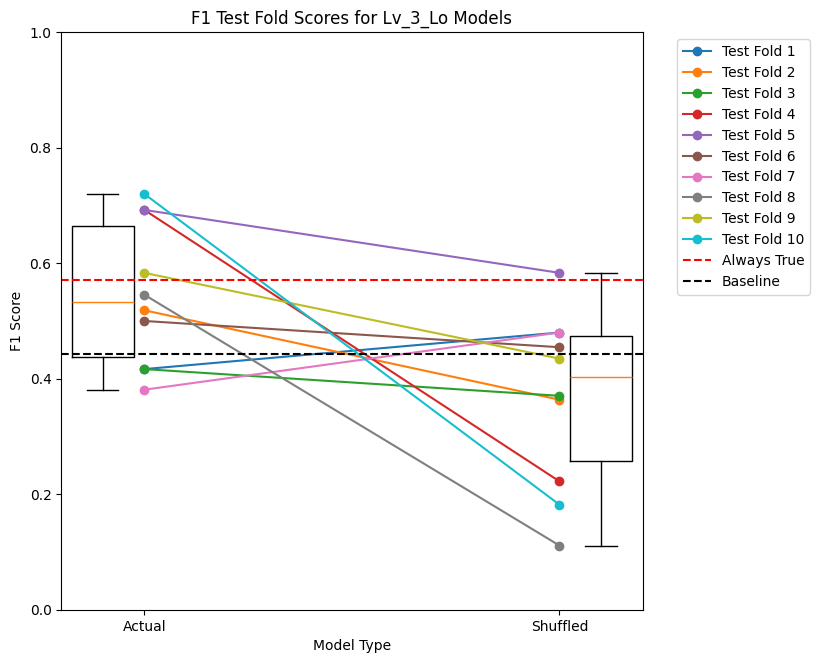

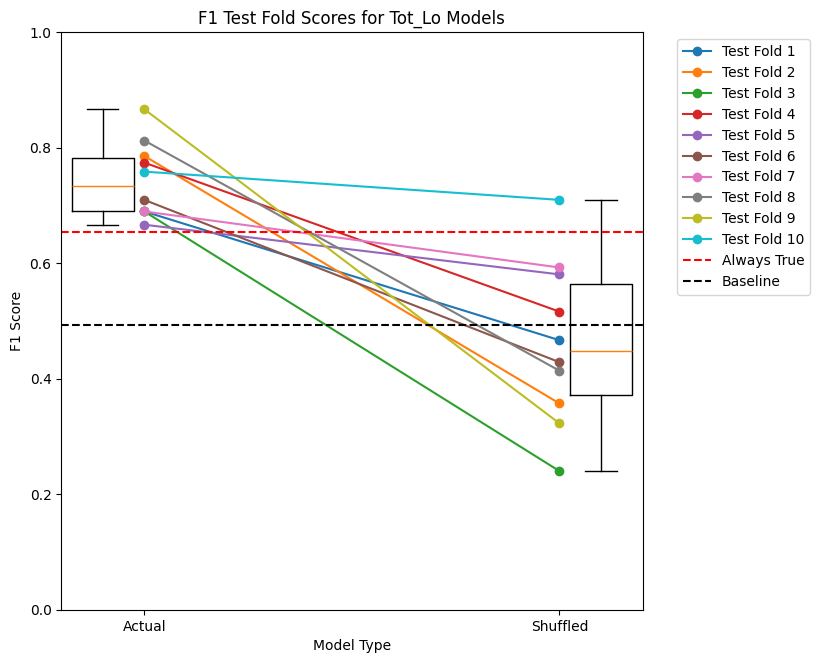

In [13]:
graph_all_actual_vs_shuffled(f1_scores, "F1")

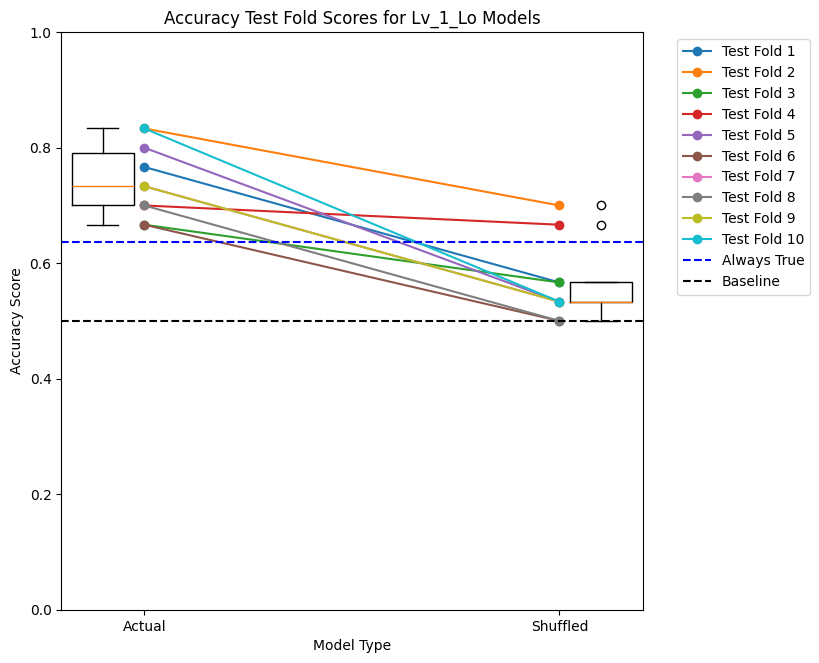

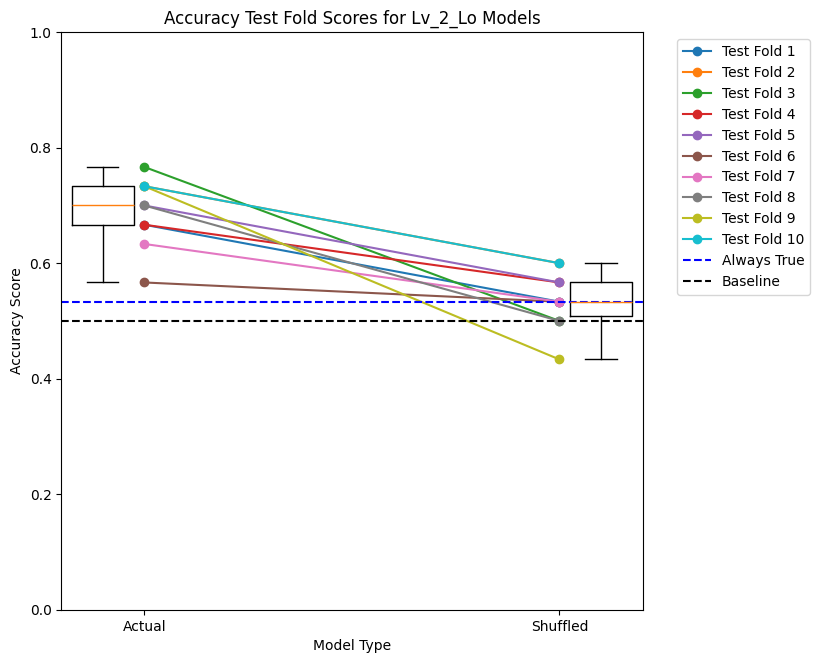

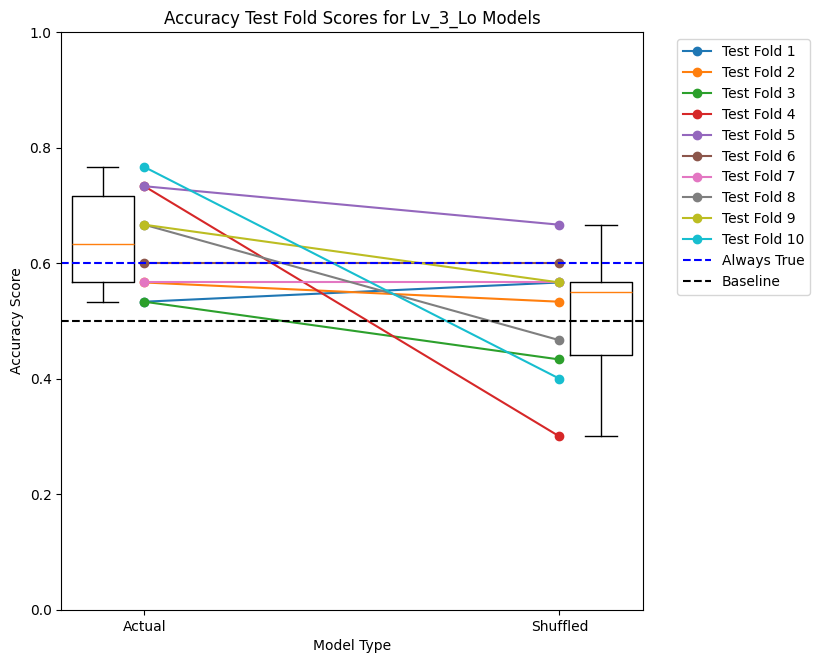

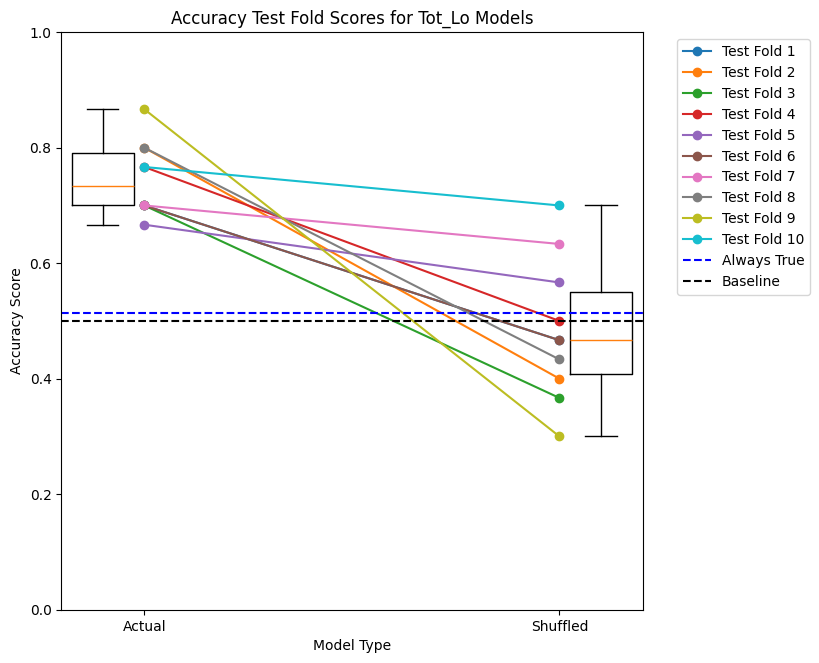

In [14]:
graph_all_actual_vs_shuffled(accuracy_scores, "Accuracy")

# Weighted Average Probability

In [4]:
# Load data
with open("./../../Pickle Files/3_Moving_Average_Model_by_Sensor_With_Intercepts.pkl", "rb") as f:
    f1_scores, accuracy_scores, models = pickle.load(f)

del f

## Get Predictions

In [5]:
# Initialize data storage
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]

weighted_average_probability_predictions = {}

for dataset in dataset_types:
    weighted_average_probability_predictions[dataset] = {}

    for level in levels:
        weighted_average_probability_predictions[dataset][level] = []

del dataset, level

In [6]:
# Tally up and store weighted average predictions
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
sensor_list_for_weighting = ["ECG", "EDA", "EEG", "EYE", "fNIRS"]
sensor_dfs = [("ECG", ECG_df), ("EDA", EDA_df), ("EEG", EEG_df), ("EYE", EYE_df), ("fNIRS", fNIRS_df)]

for dataset_type in dataset_types:
    for level in levels:
        total_f1 = 0.0
        total_accuracy = 0.0

        for sensor in sensor_list_for_weighting:
            total_f1 = np.mean(f1_scores[dataset_type][level][sensor])
            total_accuracy += np.mean(accuracy_scores[dataset_type][level][sensor])

        for i, (train_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            votes = np.array([0.0 for _ in range(len(test_idx))])

            for sensor, df in sensor_dfs:
                # Train-Test Split for the Fold
                pred_train = df.iloc[train_idx, :]
                pred_test = df.iloc[test_idx, :]

                # Standardize Data
                scaler = StandardScaler()
                pred_train_normalized = scaler.fit_transform(pred_train)
                pred_test_normalized = scaler.transform(pred_test)

                # Free Up Memory
                del pred_train, pred_train_normalized, pred_test

                combined_f1_accuracy_score = f1_scores[dataset_type][level][sensor][i] + accuracy_scores[dataset_type][level][sensor][i]
                combined_total_f1_accuracy_score = total_f1 + total_accuracy
                weight = combined_f1_accuracy_score / combined_total_f1_accuracy_score
                votes = np.add(votes, weight * models[dataset_type][level][sensor][i].predict_proba(pred_test_normalized)[:, 1])

            weighted_average_probability_predictions[dataset_type][level].append(votes >= 0.5)

del models
del skf, dataset_type, level, i, train_idx, test_idx, votes, sensor, df, pred_test_normalized, scaler

## Get F1 and Accuracy Scores

In [7]:
# Initialize f1_scores and accuracy_scores
f1_scores = {}
accuracy_scores = {}

for data in [f1_scores, accuracy_scores]:
    for dataset in dataset_types:
        data[dataset] = {}

        for level in levels:
            data[dataset][level] = []

del data, dataset, level

In [8]:
# Calculate F1 and Accuracy Scores
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for dataset_type in dataset_types:
    for lvl in levels:
        for i, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            out_test = outcomes_df.loc[test_idx, lvl].values

            f1_scores[dataset_type][lvl].append(f1_score(out_test, weighted_average_probability_predictions[dataset_type][lvl][i]))
            accuracy_scores[dataset_type][lvl].append(accuracy_score(out_test, weighted_average_probability_predictions[dataset_type][lvl][i]))

del skf, dataset_type, lvl, i, test_idx, out_test

In [12]:
# Save data
with open("./../../Pickle Files/Weighted_Average_Scores.pkl", "wb") as f:
    pickle.dump((f1_scores, accuracy_scores), f)

## Graphing

In [9]:
def graph_all_actual_vs_shuffled(model_scores, metric):
    for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
        graph_actual_vs_shuffled(model_scores, metric, level)

def graph_actual_vs_shuffled(model_scores, metric, level):
    # Intiailize Baselines
    baselines = []
    always_true_lines = []
    always_false_lines = []

    # Get baselines for each fold
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
        # Train-Test Split for the Fold
        out_test = outcomes_df.iloc[test_idx]

        if metric == "F1":
            baselines.append((np.mean(out_test[level])) / (np.mean(out_test[level]) + 0.5))
            always_true_lines.append(f1_score(out_test[level], np.array([1 for _ in range(len(out_test[level]))])))
        elif metric == "Accuracy":
            baselines.append(0.5)
            always_false_lines.append(accuracy_score(outcomes_df[level], np.array([0 for _ in range(len(outcomes_df[level]))])))

    fig = plt.figure(figsize = (7.5, 7.5))

    actual_scores = model_scores["Actual"][level]
    shuffled_scores = model_scores["Shuffled"][level]

    # Plot Actual vs Shuffled
    for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
        plt.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

    # Model 1 Data Boxplot
    plt.boxplot(actual_scores, vert = True, positions = [-0.1])

    # Shuffled Data Boxplot
    plt.boxplot(shuffled_scores, vert = True, positions = [1.1])

    # Baselines
    if metric == "F1":
        plt.axhline(y = np.mean(always_true_lines), color = "r", label = "Always True", linestyle = "--")
    elif metric == "Accuracy":
        plt.axhline(y = np.mean(always_false_lines), color = "b", label = "Always True", linestyle = "--")
    plt.axhline(y = np.mean(baselines), color = "black", label = "Baseline", linestyle = "--")

    # Visual Adjustments
    plt.xticks([0, 1], ["Actual", "Shuffled"])
    plt.xlim([-0.2, 1.2])
    plt.ylim([0, 1])
    
    # Labeling
    plt.xlabel("Model Type")
    plt.ylabel(f"{metric} Score")
    plt.title(f"{metric} Test Fold Scores for {level} Models")
    plt.legend(loc = "upper right", bbox_to_anchor = [1.3, 1])
    
    plt.show()

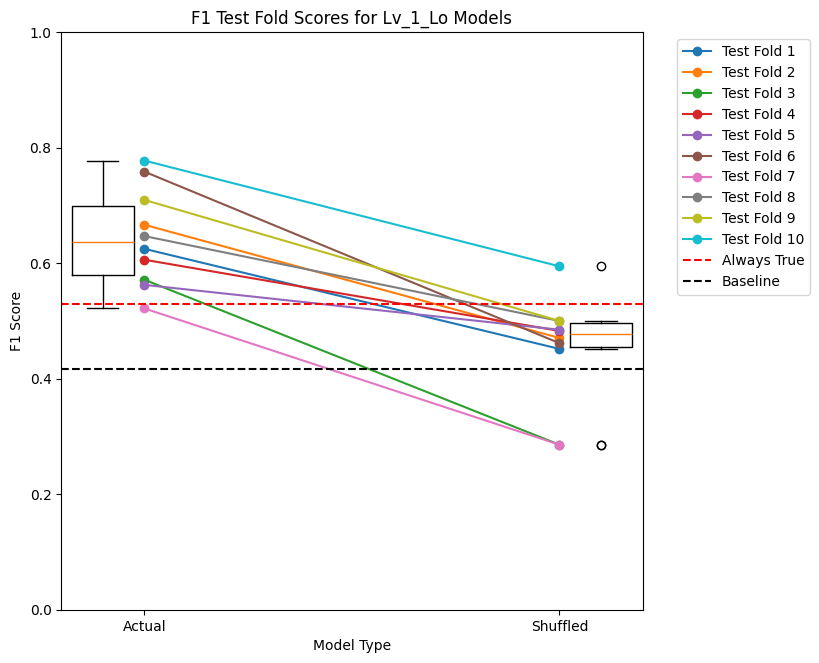

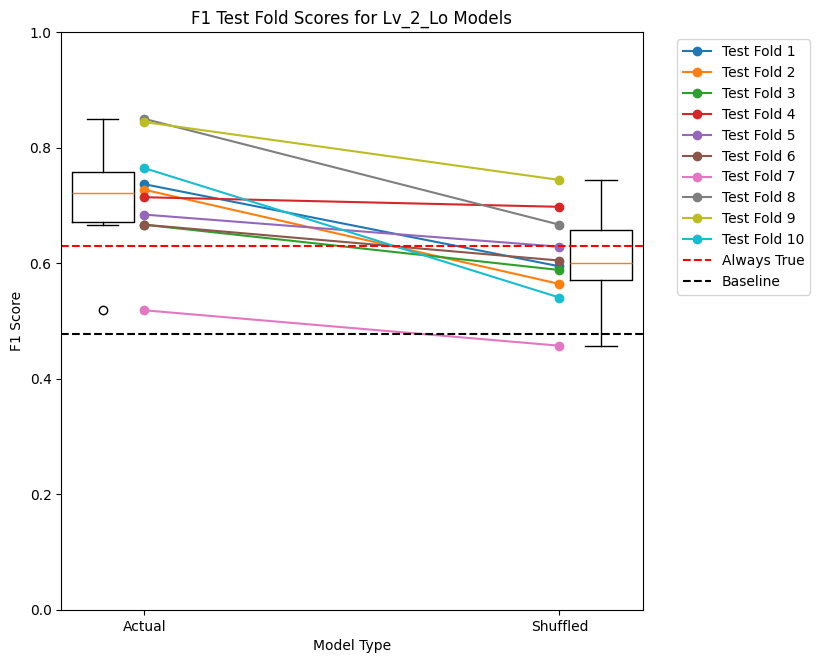

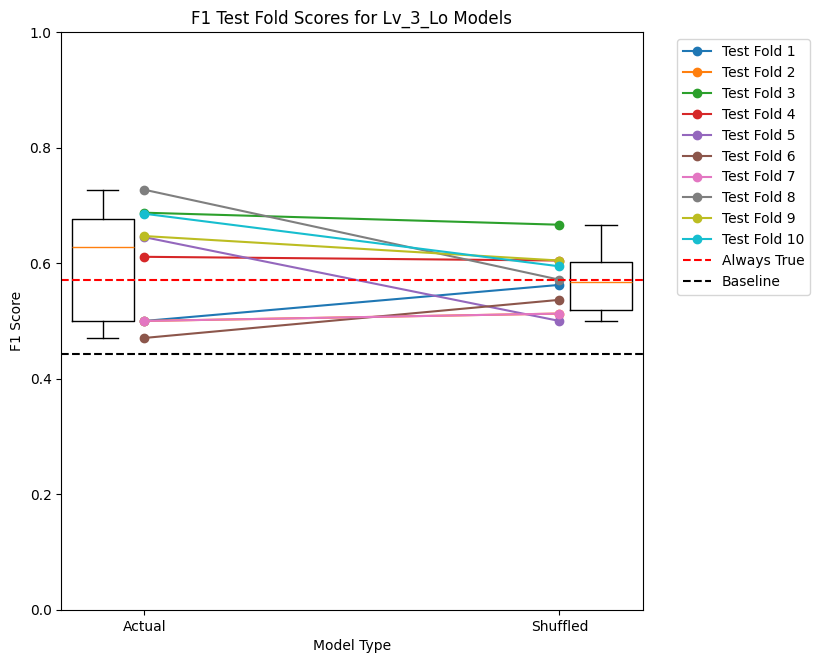

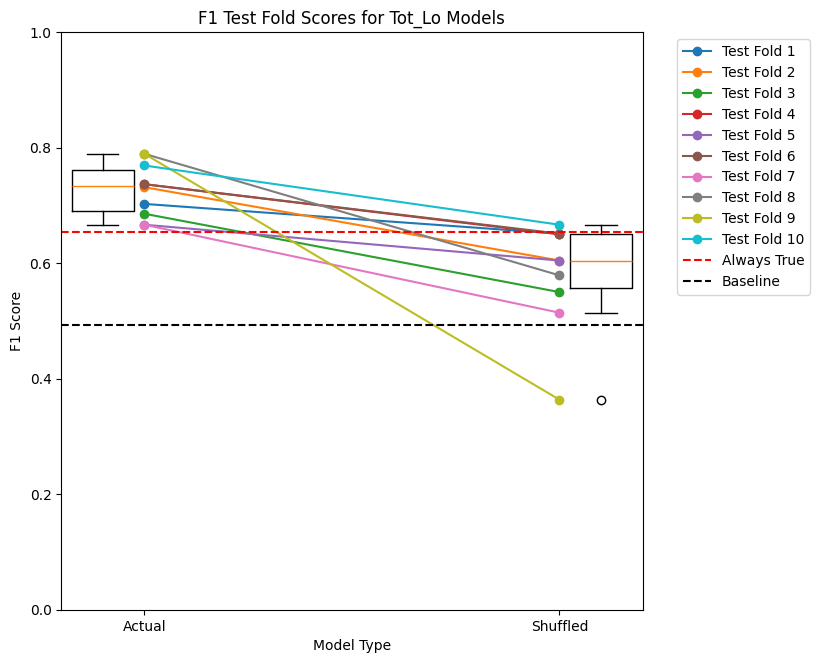

In [10]:
graph_all_actual_vs_shuffled(f1_scores, "F1")

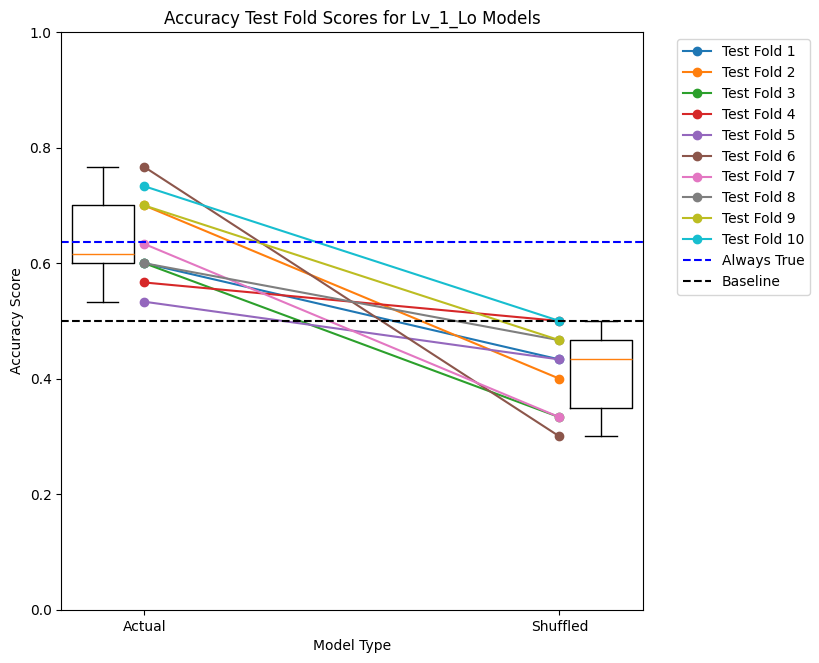

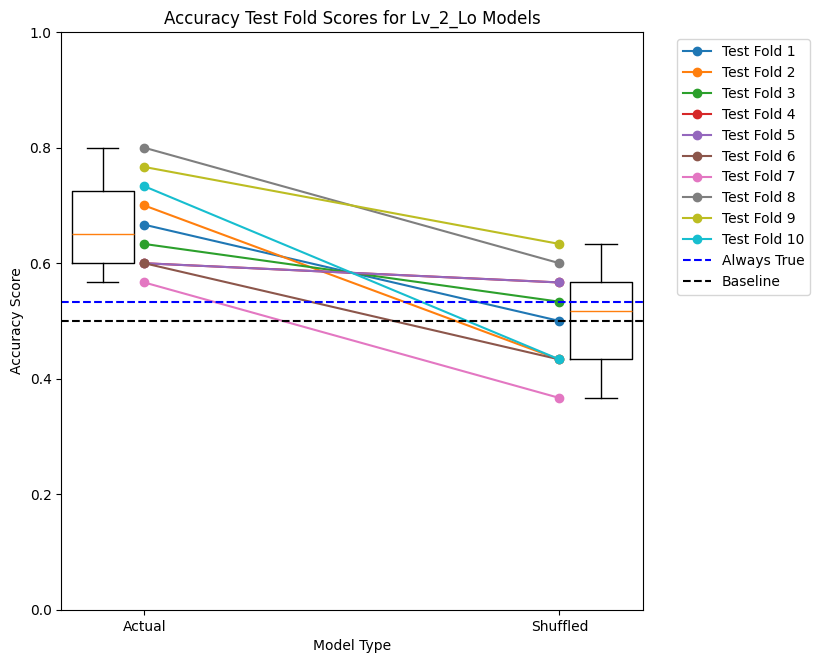

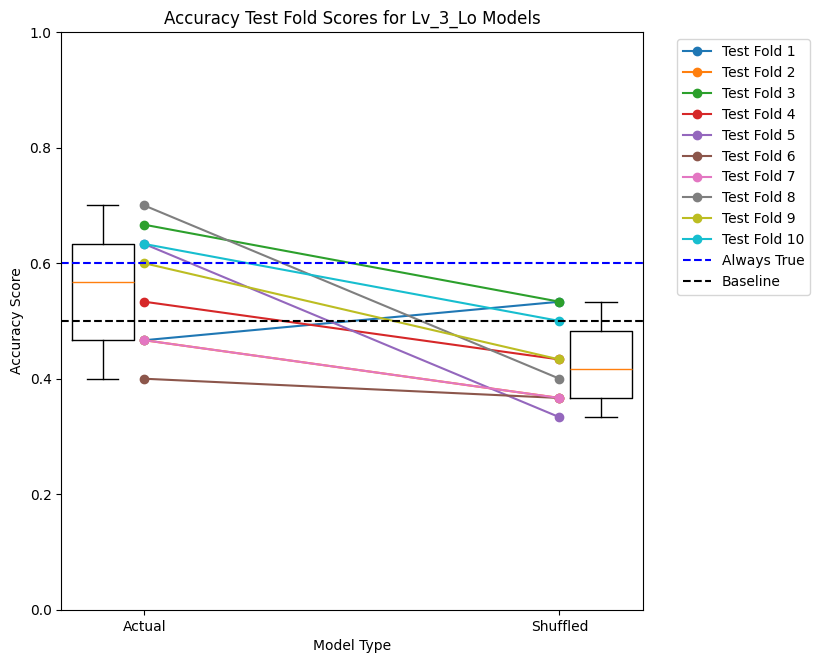

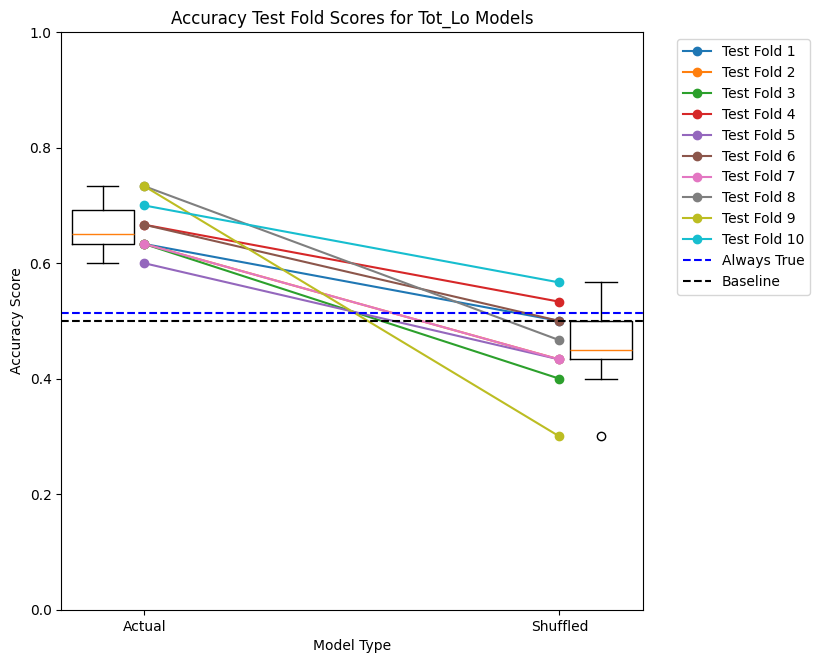

In [11]:
graph_all_actual_vs_shuffled(accuracy_scores, "Accuracy")

## Comparison to Other Models

In [5]:
# Load data
with open("./Weighted_Average_Scores.pkl", "rb") as f:
    weighted_average_probability_f1_scores, weighted_average_probability_accuracy_scores = pickle.load(f)

In [6]:
# Load data
with open("./Average_Probability_With_Intercept_Scores.pkl", "rb") as f:
    average_probability_f1_scores, average_probability_accuracy_scores = pickle.load(f)

In [15]:
# Load data
with open("./Average_Probability_Model_Scores.pkl", "rb") as f:
    average_probability_no_intercept_f1_scores, average_probability_no_intercept_accuracy_scores = pickle.load(f)

In [16]:
# Load data
with open("./Weighted_Average_No_Intercept_Scores.pkl", "rb") as f:
    weighted_average_probability_no_intercept_f1_scores, weighted_average_probability_no_intercept_accuracy_scores = pickle.load(f)

In [13]:
def run_t_tests(model_f1_scores, model_accuracy_scores, outcomes_df, lvl, ids):
    print(lvl)

    # Actual vs Shuffled for F1
    print("Paired (Actual vs. Shuffled) (F1)")
    actual_vs_shuffled_t_test(model_f1_scores, lvl)

    # Actual vs Shuffled for Accuracy
    print("Paired (Actual vs. Shuffled) (Accuracy)")
    actual_vs_shuffled_t_test(model_accuracy_scores, lvl)

    # Get Baselines for F1 and Accuracy
    f1_baseline, f1_always_true_baseline, accuracy_baseline, accuracy_always_false_baseline = get_baselines(outcomes_df, lvl, ids)

    # vs F1 Baseline
    print("vs F1 Baseline")
    one_sample_t_test(model_f1_scores, f1_baseline, lvl)

    # vs F1 Always True Baseline
    print("vs F1 Always True Baseline")
    one_sample_t_test(model_f1_scores, f1_always_true_baseline, lvl)
    
    # vs Accuracy Baseline
    print("vs 0.5 Baseline")
    one_sample_t_test(model_accuracy_scores, accuracy_baseline, lvl)

    # vs Accuracy Always False Baseline
    print("vs Accuracy Always False Baseline")
    one_sample_t_test(model_accuracy_scores, accuracy_always_false_baseline, lvl)

def actual_vs_shuffled_t_test(model_scores, lvl):
    print(f'{"t" : <7}{"p" : <7}')
    t_stat, p_val = stats.ttest_rel(
        model_scores["Actual"][lvl],
        model_scores["Shuffled"][lvl]
    )
    print(f'{t_stat : <7.3f}{p_val : >5.3f}')
    print()

def paired_t_test(model_1_scores, model_2_scores, lvl):
    print(f'{"t" : <7}{"p" : <7}')
    t_stat, p_val = stats.ttest_rel(
        model_1_scores["Actual"][lvl],
        model_2_scores["Actual"][lvl]
    )
    print(f'{t_stat : <7.3f}{p_val : >5.3f}')
    print()

def paired_t_test_weird(model_1_scores, model_2_scores, lvl):
    print(f'{"t" : <7}{"p" : <7}')
    t_stat, p_val = stats.ttest_rel(
        model_1_scores["Actual"][lvl],
        model_2_scores["Actual"][lvl]["Ridge"]
    )
    print(f'{t_stat : <7.3f}{p_val : >5.3f}')
    print()

def get_baselines(outcomes_df, lvl, ids):
    baseline_f1_scores = []
    baseline_f1_always_true_scores = []
    baseline_accuracy_score = 0.5
    baseline_accuracy_always_false_scores = []

    # Gather Baselines for Each Fold
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (CV_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
        out_test = outcomes_df.loc[test_idx, lvl].values

        # Calculate F1 Baseline
        precision = np.mean(out_test)
        recall = 0.5
        baseline_f1_scores.append(np.mean((2 * precision * recall) / (precision + recall)))

        # Calculate F1 Always True Baseline
        baseline_f1_always_true_scores.append(f1_score(out_test, np.array([1 for _ in range(len(out_test))])))

        # Calculate Accuracy Always False Baseline
        baseline_accuracy_always_false_scores.append(accuracy_score(out_test, np.array([0 for _ in range(len(out_test))])))

    return (np.mean(baseline_f1_scores), np.mean(baseline_f1_always_true_scores), baseline_accuracy_score, np.mean(baseline_accuracy_always_false_scores))

def one_sample_t_test(model_scores, baseline_score, lvl):
    print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
    t_stat, p_val = stats.ttest_1samp(
        a = model_scores["Actual"][lvl], 
        popmean = np.mean(baseline_score))
    print(f'{t_stat : <7.3f}{p_val : >5.3f}')
    print()

In [15]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    run_t_tests(f1_scores, accuracy_scores, outcomes_df, level, ids)

Lv_1_Lo
Paired (Actual vs. Shuffled) (F1)
t      p      
8.896  0.000

Paired (Actual vs. Shuffled) (Accuracy)
t      p      
6.107  0.000

vs F1 Baseline
Penalty                       t      p      
8.528  0.000

vs F1 Always True Baseline
Penalty                       t      p      
4.337  0.002

vs 0.5 Baseline
Penalty                       t      p      
5.882  0.000

vs Accuracy Always False Baseline
Penalty                       t      p      
0.274  0.791

Lv_2_Lo
Paired (Actual vs. Shuffled) (F1)
t      p      
5.177  0.001

Paired (Actual vs. Shuffled) (Accuracy)
t      p      
5.710  0.000

vs F1 Baseline
Penalty                       t      p      
7.928  0.000

vs F1 Always True Baseline
Penalty                       t      p      
2.870  0.018

vs 0.5 Baseline
Penalty                       t      p      
6.578  0.000

vs Accuracy Always False Baseline
Penalty                       t      p      
5.262  0.001

Lv_3_Lo
Paired (Actual vs. Shuffled) (F1)
t      p      
1.244  

In [14]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    run_t_tests(weighted_average_probability_f1_scores, weighted_average_probability_accuracy_scores, outcomes_df, level, ids)

NameError: name 'weighted_average_probability_f1_scores' is not defined

In [13]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    paired_t_test(weighted_average_probability_f1_scores, average_probability_f1_scores, level)

for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    paired_t_test(weighted_average_probability_accuracy_scores, average_probability_accuracy_scores, level)

t      p      
-1.100 0.300

t      p      
0.710  0.496

t      p      
1.914  0.088

t      p      
1.442  0.183

t      p      
-0.557 0.591

t      p      
0.818  0.434

t      p      
2.449  0.037

t      p      
1.909  0.089



In [22]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print("F1 for " + level)
    paired_t_test_weird(weighted_average_probability_f1_scores, average_probability_no_intercept_f1_scores, level)

for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print("Accuracy for " + level)
    paired_t_test_weird(weighted_average_probability_accuracy_scores, average_probability_no_intercept_accuracy_scores, level)

F1 for Lv_1_Lo
t      p      
-1.082 0.307

F1 for Lv_2_Lo
t      p      
0.076  0.941

F1 for Lv_3_Lo
t      p      
-2.442 0.037

F1 for Tot_Lo
t      p      
2.284  0.048

Accuracy for Lv_1_Lo
t      p      
-0.126 0.903

Accuracy for Lv_2_Lo
t      p      
-0.124 0.904

Accuracy for Lv_3_Lo
t      p      
-0.519 0.616

Accuracy for Tot_Lo
t      p      
2.025  0.074



In [9]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print("F1 for " + level)
    paired_t_test(weighted_average_probability_f1_scores, weighted_average_probability_no_intercept_f1_scores, level)

for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print("Accuracy for " + level)
    paired_t_test(weighted_average_probability_accuracy_scores, weighted_average_probability_no_intercept_accuracy_scores, level)

F1 for Lv_1_Lo
t      p      
-0.502 0.628

F1 for Lv_2_Lo
t      p      
1.579  0.149

F1 for Lv_3_Lo
t      p      
-2.348 0.043

F1 for Tot_Lo
t      p      
2.951  0.016

Accuracy for Lv_1_Lo
t      p      
0.130  0.899

Accuracy for Lv_2_Lo
t      p      
1.964  0.081

Accuracy for Lv_3_Lo
t      p      
-1.304 0.225

Accuracy for Tot_Lo
t      p      
2.091  0.066

